In [ ]:
#Preprocessing Data
import os
import pandas as pd
import pickle
import ast
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

#modelling
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Evaluasi Model
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score

#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model_xception = tf.keras.models.load_model('/content/drive/MyDrive/Data Skripsi/Save Model Xception.h5')

# Show the model architecture
model_xception.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model_irv2 = tf.keras.models.load_model('/content/drive/MyDrive/Data Skripsi/Save Model irv2.h5')

# Show the model architecture
model_irv2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_203 (Conv2D)         (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_203 (B  (None, 149, 149, 32)         96        ['conv2d_203[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_203 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_20

In [ ]:
# Import data
file = "/content/drive/MyDrive/Data Skripsi/Data Film.xlsx"
df = pd.read_excel(file)

# Mengurutkan berdasarkan Id Film dan Mengambil 1000 data
df = df.head(1000)
df = df.sort_values(by=['Id Film']).reset_index(drop=True)
df

,Id Film,Genre
0,tt10011534,['Drama']
1,tt1003552,['Horror']
2,tt10039546,"['Comedy', 'Drama']"
3,tt10043746,['Drama']
4,tt10056322,['Drama']
...,...,...
995,tt9818102,"['Comedy', 'Drama']"
996,tt9824016,['Horror']
997,tt9828814,['Horror']
998,tt9900552,['Horror']


In [ ]:
# Parsing string ke dalam list menggunakan modul ast
df['Genre'] = df['Genre'].apply(ast.literal_eval)

# Encoding Label
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(df['Genre'])
binary_df = pd.DataFrame(binary_labels, columns = mlb.classes_)

# Menggabungkan Data Asli dan hasil encoding label
df_fix = pd.concat([df, binary_df], axis=1)
df_fix

,Id Film,Genre,Action,Comedy,Drama,Horror,Romance
0,tt10011534,[Drama],0,0,1,0,0
1,tt1003552,[Horror],0,0,0,1,0
2,tt10039546,"[Comedy, Drama]",0,1,1,0,0
3,tt10043746,[Drama],0,0,1,0,0
4,tt10056322,[Drama],0,0,1,0,0
...,...,...,...,...,...,...,...
995,tt9818102,"[Comedy, Drama]",0,1,1,0,0
996,tt9824016,[Horror],0,0,0,1,0
997,tt9828814,[Horror],0,0,0,1,0
998,tt9900552,[Horror],0,0,0,1,0


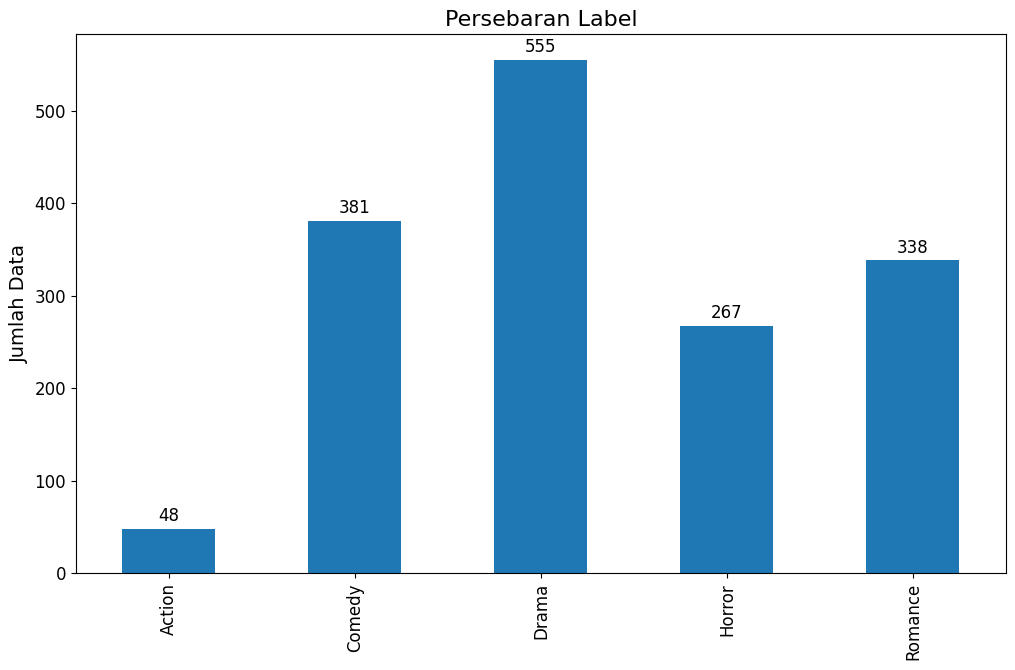

In [ ]:
# Plot bar chart
plt.figure(figsize=(12, 7))
bars = df_fix.drop(['Id Film', 'Genre'],axis=1).sum().plot(kind='bar')

# Tambahkan nilai label ke setiap batang
for bar in bars.patches:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords='offset points',
                 ha='center', va='bottom', size=12)

plt.title('Persebaran Label', size=16)
plt.ylabel('Jumlah Data', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

plt.show()

# Splitting Data

In [ ]:
X = []
for i in tqdm(range(df_fix.shape[0])):
  path = '/content/drive/MyDrive/Data Skripsi/Posters/'+ df_fix['Id Film'][i] + ".jpg"
  img = image.load_img(path,target_size=(299,299,3))
  img = image.img_to_array(img)
  img = img/255.0
  X.append(img)

X = np.array(X)

y = df_fix.drop(['Id Film', 'Genre'],axis=1)
y = y.to_numpy()

 78%|███████▊  | 784/1000 [00:10<00:04, 52.58it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (97653348 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 83%|████████▎ | 830/1000 [00:11<00:03, 45.32it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (112266000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1000/1000 [00:15<00:00, 66.60it/s]


In [ ]:
# Pembagian data menjadi set pelatihan (70%) dan sisa (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Pembagian data sisa menjadi set validasi (20%) dan set pengujian (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# Multi-Label Random Oversampling

In [ ]:
import numpy as np
import time

def IRLbl(labels):
    N, C = labels.shape
    pos_nums_per_label = np.sum(labels, axis=0)
    max_pos_nums = np.max(pos_nums_per_label)
    return max_pos_nums / pos_nums_per_label

def MeanIR(labels):
    IRLbl_VALUE = IRLbl(labels)
    return np.mean(IRLbl_VALUE)

def ML_ROS(all_labels, indices=None, num_samples=None, Preset_MeanIR_value=2.,
                 max_clone_percentage=50, sample_size=32):
    indices = list(range(len(all_labels))) if indices is None else indices
    num_samples = len(indices) if num_samples is None else num_samples

    MeanIR_value = MeanIR(all_labels) if Preset_MeanIR_value == 0 else Preset_MeanIR_value
    IRLbl_value = IRLbl(all_labels)
    N, C = all_labels.shape
    indices_per_class = {}
    minority_classes = []
    maxSamplesToClone = N / 100 * max_clone_percentage
    print('Max Clone Limit:', maxSamplesToClone)
    for i in range(C):
        ids = all_labels[:, i] == 1
        indices_per_class[i] = [ii for ii, x in enumerate(ids) if x]
        if IRLbl_value[i] > MeanIR_value:
            minority_classes.append(i)

    new_all_labels = all_labels
    oversampled_ids = []
    minorNum = len(minority_classes)
    print(minorNum, 'minor classes.')

    for idx, i in enumerate(minority_classes):
        tid = time.time()
        while True:
            pick_id = list(np.random.choice(indices_per_class[i], sample_size))
            indices_per_class[i].extend(pick_id)
            new_all_labels = np.concatenate([new_all_labels, all_labels[pick_id].astype(new_all_labels.dtype)], axis=0)
            oversampled_ids.extend(pick_id)

            newIrlbl = IRLbl(new_all_labels)
            if newIrlbl[i] <= MeanIR_value:
                print('\nMeanIR satisfied.', newIrlbl[i])
                break
            if len(oversampled_ids) >= maxSamplesToClone:
                print('\nExceed max clone.', len(oversampled_ids))
                break
            print("\roversample length:{}".format(len(oversampled_ids)), end='')
        print('Processed the %d/%d minor class:' % (idx + 1, minorNum), i, time.time() - tid, 's')
        if len(oversampled_ids) >= maxSamplesToClone:
            print('Exceed max clone. Exit', len(oversampled_ids))
            break
    return new_all_labels, oversampled_ids

# Step 3: Apply ML_ROS on training labels
new_y_train, oversampled_ids = ML_ROS(y_train)

# Find the oversampled rows in the training set
oversampled_rows = X_train[oversampled_ids]

# Combine original training data with oversampled rows
augmented_X_train = np.concatenate((X_train, oversampled_rows), axis=0)
augmented_y_train = np.concatenate((y_train, new_y_train[len(y_train):]), axis=0)


Max Clone Limit: 350.0
2 minor classes.
oversample length:192
MeanIR satisfied. 1.9805447470817121
Processed the 1/2 minor class: 0 0.005831241607666016 s
oversample length:288
MeanIR satisfied. 1.9040590405904059
Processed the 2/2 minor class: 3 0.002013683319091797 s


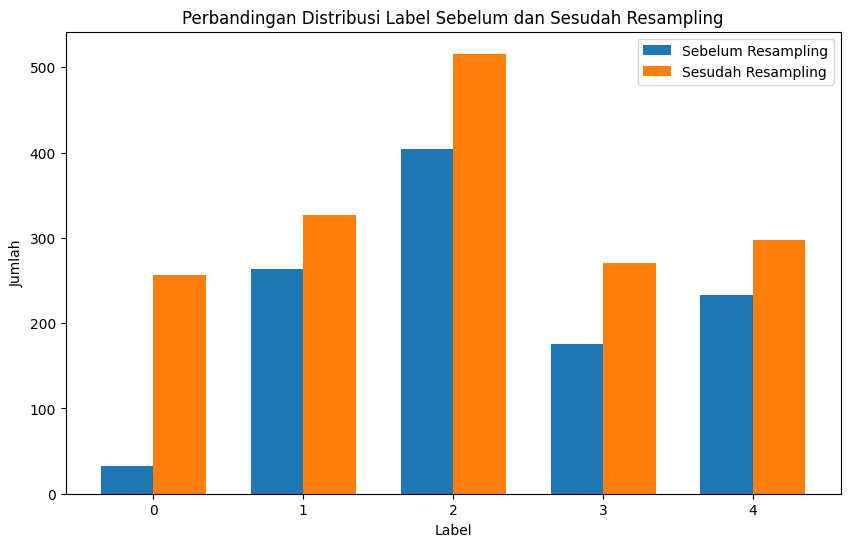

In [ ]:
# Mengonversi data ke DataFrame
df_sebelum = pd.DataFrame(y_train)
df_sesudah = pd.DataFrame(augmented_y_train)

# Menghitung distribusi label
distribusi_sebelum = df_sebelum.sum().reset_index()
distribusi_sebelum.columns = ['Label', 'Jumlah Sebelum']

distribusi_sesudah = df_sesudah.sum().reset_index()
distribusi_sesudah.columns = ['Label', 'Jumlah Sesudah']

# Menggabungkan distribusi ke dalam satu DataFrame
distribusi = distribusi_sebelum.merge(distribusi_sesudah, on='Label')

# Membuat plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(distribusi))

# Plot barchart untuk data sebelum resampling
plt.bar(index, distribusi['Jumlah Sebelum'], bar_width, label='Sebelum Resampling')

# Plot barchart untuk data sesudah resampling
plt.bar([i + bar_width for i in index], distribusi['Jumlah Sesudah'], bar_width, label='Sesudah Resampling')

# Menambahkan label dan judul
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Perbandingan Distribusi Label Sebelum dan Sesudah Resampling')
plt.xticks([i + bar_width / 2 for i in index], distribusi['Label'])
plt.legend()

# Menampilkan plot
plt.show()

# InceptionResNetV2



In [ ]:
from tensorflow.keras.regularizers import l1, l2, l1_l2
# Membuat model Xception
base_model_irv2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=augmented_X_train[0].shape)

model_irv2 = base_model_irv2.output
model_irv2 = GlobalAveragePooling2D()(model_irv2)
model_irv2 = Dense(512, activation = 'relu')(model_irv2)
model_irv2 = Dropout(0.5)(model_irv2)
model_irv2 = Dense(256, activation = 'relu')(model_irv2)
model_irv2 = Dropout(0.5)(model_irv2)
model_irv2 = Dense(5,activation='sigmoid')(model_irv2)
model_irv2 = Model(inputs=base_model_irv2.input, outputs = model_irv2)

# Membekukan layer-layer pada base model
for layer in base_model_irv2.layers[:len(base_model_irv2.layers)*3//4]:
    layer.trainable = False

# Kompilasi model
model_irv2.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Membuat generator untuk augmentasi data
augment_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Pelatihan model
history = model_irv2.fit(augment_generator.flow(augmented_X_train, augmented_y_train),
                             validation_data=(X_val, y_val),
                             batch_size = 32,
                             epochs = 100,
                             callbacks=[early_stopping, reduce_lr])

Epoch 1/100
32/32 [==============================] - 49s 756ms/step - loss: 0.7531 - accuracy: 0.2382 - val_loss: 0.6983 - val_accuracy: 0.2050 - lr: 1.0000e-05
Epoch 2/100
32/32 [==============================] - 21s 645ms/step - loss: 0.6867 - accuracy: 0.2451 - val_loss: 0.6325 - val_accuracy: 0.2750 - lr: 1.0000e-05
Epoch 3/100
32/32 [==============================] - 21s 648ms/step - loss: 0.6464 - accuracy: 0.2755 - val_loss: 0.6013 - val_accuracy: 0.3750 - lr: 1.0000e-05
Epoch 4/100
32/32 [==============================] - 21s 644ms/step - loss: 0.6311 - accuracy: 0.2598 - val_loss: 0.5813 - val_accuracy: 0.4200 - lr: 1.0000e-05
Epoch 5/100
32/32 [==============================] - 21s 659ms/step - loss: 0.6110 - accuracy: 0.2696 - val_loss: 0.5664 - val_accuracy: 0.4450 - lr: 1.0000e-05
Epoch 6/100
32/32 [==============================] - 21s 654ms/step - loss: 0.5980 - accuracy: 0.2882 - val_loss: 0.5499 - val_accuracy: 0.4700 - lr: 1.0000e-05
Epoch 7/100
32/32 [===============

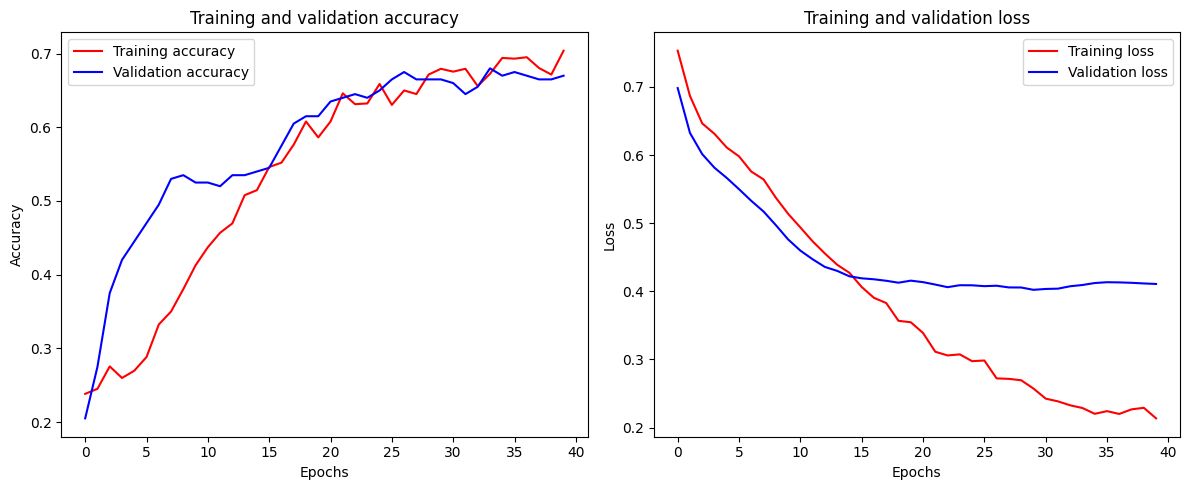

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Create a single figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy on the first subplot
ax1.plot(epochs, acc, 'r', label='Training accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

# Plot loss on the second subplot
ax2.plot(epochs, loss, 'r', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='best')

# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Show the figure
plt.show()

In [ ]:
pred_irv2 = model_irv2.predict(X_test)
pred_irv2

4/4 [==============================] - 13s 851ms/step


array([[8.80125985e-02, 3.23679358e-01, 5.72635531e-01, 1.58313408e-01,
        8.66171494e-02],
       [1.04019620e-01, 1.76521122e-01, 7.41687953e-01, 1.53618604e-01,
        6.21344328e-01],
       [3.34365061e-03, 3.43075767e-02, 1.10824974e-02, 9.95995164e-01,
        1.26758486e-03],
       [2.84355460e-03, 2.35696901e-02, 1.14489794e-02, 9.95942771e-01,
        2.23471224e-03],
       [2.78305560e-02, 5.92716753e-01, 9.07960594e-01, 2.22622976e-02,
        6.17295325e-01],
       [1.04586743e-01, 7.05345646e-02, 9.66956556e-01, 1.30754542e-02,
        7.69281566e-01],
       [7.52473399e-02, 4.57429916e-01, 6.96294665e-01, 5.51754162e-02,
        3.75742286e-01],
       [4.55776639e-02, 1.76060051e-01, 6.44525409e-01, 2.39060119e-01,
        2.24782258e-01],
       [1.03841042e-02, 3.18925560e-01, 9.55524921e-01, 6.15913048e-03,
        8.68002772e-01],
       [5.82830049e-03, 2.61767246e-02, 5.48351929e-03, 9.93299246e-01,
        5.92798402e-04],
       [7.94905499e-02, 8.9041

In [ ]:
y_pred_irv2=[]
for sample in pred_irv2:
    y_pred_irv2.append([1 if i>=0.5 else 0 for i in sample ] )
y_pred_irv2 = np.array(y_pred_irv2)

In [ ]:
# Membuat DataFrame dari data
df_true = pd.DataFrame(y_test, columns=['Action', 'Comedy', 'Drama', 'Horror', 'Romance'])
df_pred_irv2 = pd.DataFrame(y_pred_irv2, columns=['Action', 'Comedy', 'Drama', 'Horror', 'Romance'])

# Menggabungkan DataFrame y_true dan y_pred untuk visualisasi
df_combined_irv2 = pd.concat([df_true.add_prefix('y_true_'), df_pred_irv2.add_prefix('y_pred_')], axis=1)

In [ ]:
# Tentukan path untuk menyimpan file Excel di Google Drive
excel_file_path = '/content/drive/My Drive/Data Skripsi/Data Label Aktual dan Label Prediksi InceptionResNetV2.xlsx'

# Menyimpan DataFrame ke dalam file Excel
df_combined_irv2.to_excel(excel_file_path, index=False)

In [ ]:
def hamming_loss(y_true, y_pred):
  temp=0
  for i in range(y_true.shape[0]):
    temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
  return temp/(y_true.shape[0] * y_true.shape[1])

# Hitung Hamming Loss
loss = hamming_loss(y_test, y_pred_irv2)
print("Hamming Loss:", loss)

Hamming Loss: 0.176


In [ ]:
def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
      temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]
Accuracy(y_test, y_pred_irv2)

0.6433333333333334

# Xception

In [ ]:
from tensorflow.keras.regularizers import l1, l2, l1_l2
# Membuat model Xception
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=augmented_X_train[0].shape)

model_xception = base_model_xception.output
model_xception = GlobalAveragePooling2D()(model_xception)
model_xception = Dense(512, activation = 'relu')(model_xception)
model_xception = Dropout(0.5)(model_xception)
model_xception = Dense(256, activation = 'relu')(model_xception)
model_xception = Dropout(0.5)(model_xception)
model_xception = Dense(5,activation='sigmoid')(model_xception)
model_xception = Model(inputs=base_model_xception.input, outputs = model_xception)

# Membekukan layer-layer pada base model
for layer in base_model_xception.layers[:len(base_model_xception.layers)*3//4]:
    layer.trainable = False

# Kompilasi model
model_xception.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Membuat generator untuk augmentasi data
augment_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Pelatihan model
history = model_xception.fit(augment_generator.flow(augmented_X_train, augmented_y_train),
                             validation_data=(X_val, y_val),
                             batch_size = 32,
                             epochs = 100,
                             callbacks=[early_stopping, reduce_lr])

Epoch 1/100
32/32 [==============================] - 46s 933ms/step - loss: 0.6847 - accuracy: 0.2059 - val_loss: 0.6481 - val_accuracy: 0.3000 - lr: 1.0000e-05
Epoch 2/100
32/32 [==============================] - 21s 644ms/step - loss: 0.6540 - accuracy: 0.2392 - val_loss: 0.6213 - val_accuracy: 0.3450 - lr: 1.0000e-05
Epoch 3/100
32/32 [==============================] - 21s 654ms/step - loss: 0.6377 - accuracy: 0.2363 - val_loss: 0.6043 - val_accuracy: 0.3400 - lr: 1.0000e-05
Epoch 4/100
32/32 [==============================] - 21s 643ms/step - loss: 0.6267 - accuracy: 0.2451 - val_loss: 0.5930 - val_accuracy: 0.3300 - lr: 1.0000e-05
Epoch 5/100
32/32 [==============================] - 21s 632ms/step - loss: 0.6119 - accuracy: 0.2804 - val_loss: 0.5852 - val_accuracy: 0.3450 - lr: 1.0000e-05
Epoch 6/100
32/32 [==============================] - 21s 636ms/step - loss: 0.6039 - accuracy: 0.2549 - val_loss: 0.5773 - val_accuracy: 0.3450 - lr: 1.0000e-05
Epoch 7/100
32/32 [===============

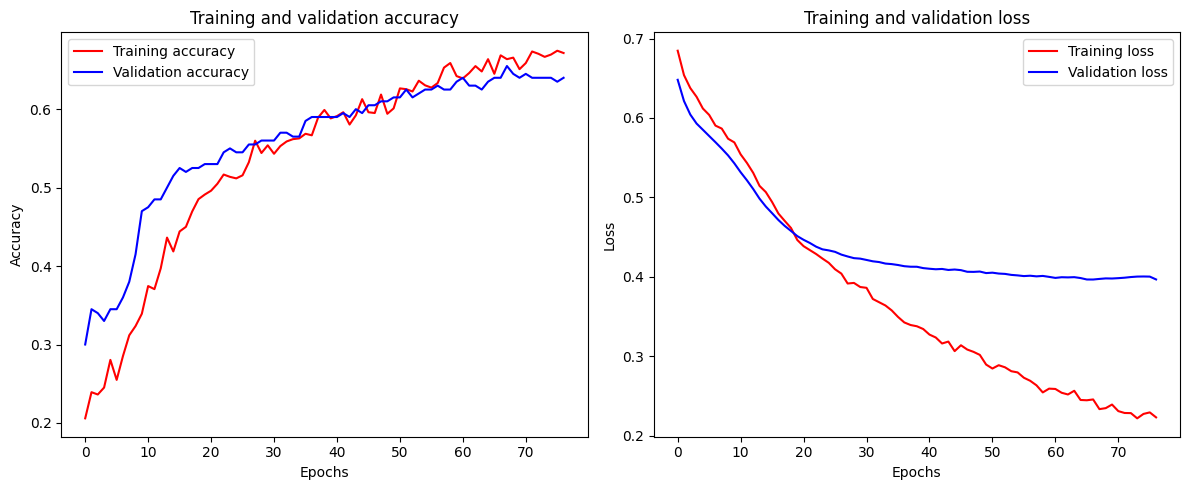

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Create a single figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy on the first subplot
ax1.plot(epochs, acc, 'r', label='Training accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

# Plot loss on the second subplot
ax2.plot(epochs, loss, 'r', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='best')

# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Show the figure
plt.show()

In [ ]:
pred_xception = model_xception.predict(X_test)
pred_xception

4/4 [==============================] - 8s 721ms/step


array([[6.68858290e-02, 2.12890074e-01, 2.08281517e-01, 6.72410786e-01,
        4.67882827e-02],
       [2.75413990e-02, 1.13465026e-01, 9.32778656e-01, 4.90910746e-02,
        7.53089368e-01],
       [4.24569985e-03, 6.27085418e-02, 3.80168632e-02, 9.89575386e-01,
        2.53992062e-03],
       [1.69022533e-03, 5.81064522e-02, 4.32084724e-02, 9.87746477e-01,
        5.25481673e-03],
       [2.02828273e-02, 3.43756467e-01, 8.27669740e-01, 3.32331732e-02,
        7.33066559e-01],
       [3.18172686e-02, 1.64729878e-01, 7.87861884e-01, 1.33632347e-01,
        5.75415909e-01],
       [3.33281606e-01, 6.17698908e-01, 5.26873469e-01, 4.09239568e-02,
        1.48619115e-01],
       [3.44683886e-01, 8.09454173e-02, 3.81238461e-01, 3.08865428e-01,
        9.45585892e-02],
       [9.66827571e-03, 4.40272629e-01, 8.94494236e-01, 1.03304721e-02,
        6.38057470e-01],
       [1.15273939e-02, 1.67596415e-02, 2.15669535e-03, 9.96248424e-01,
        8.99279315e-04],
       [7.85278752e-02, 8.9423

In [ ]:
y_pred_xception=[]
for sample in pred_xception:
    y_pred_xception.append([1 if i>=0.5 else 0 for i in sample ] )
y_pred_xception = np.array(y_pred_xception)

In [ ]:
# Membuat DataFrame dari data
df_true = pd.DataFrame(y_test, columns=['Action', 'Comedy', 'Drama', 'Horror', 'Romance'])
df_pred_xception = pd.DataFrame(y_pred_xception, columns=['Action', 'Comedy', 'Drama', 'Horror', 'Romance'])

# Menggabungkan DataFrame y_true dan y_pred untuk visualisasi
df_combined_xception = pd.concat([df_true.add_prefix('y_true_'), df_pred_xception.add_prefix('y_pred_')], axis=1)

In [ ]:
# Tentukan path untuk menyimpan file Excel di Google Drive
excel_file_path = '/content/drive/My Drive/Data Skripsi/Data Label Aktual dan Label Prediksi Xception.xlsx'

# Menyimpan DataFrame ke dalam file Excel
df_combined_xception.to_excel(excel_file_path, index=False)

In [ ]:
def hamming_loss(y_true, y_pred):
  temp=0
  for i in range(y_true.shape[0]):
    temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
  return temp/(y_true.shape[0] * y_true.shape[1])

# Hitung Hamming Loss
loss = hamming_loss(y_test, y_pred_xception)
print("Hamming Loss:", loss)

Hamming Loss: 0.138


In [ ]:
def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
      temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]
Accuracy(y_test, y_pred_xception)

0.6983333333333333

In [ ]:
# Save the trained model
model_xception.save("/content/drive/My Drive/Data Skripsi/Save Model Xception.h5", include_optimizer=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Save the trained model
model_irv2.save("/content/drive/My Drive/Data Skripsi/Save Model irv2.h5", include_optimizer=True)

# Cek Hasil Ekstraksi Fitur

In [ ]:
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D
import numpy as np

import os
import pandas as pd

# Function to extract features from a single image
def _get_features(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    IRV2_features = base_model_irv2.predict(img_data)
    return IRV2_features

# Directory containing images
img_dir = "/content/drive/MyDrive/Data Skripsi/Posters/"

# List to store features and filenames
features_list = []
id_films_list = []

# Iterate over each image in the directory
for id_film in os.listdir(img_dir):
    if id_film.endswith(".jpg"):
        img_path = os.path.join(img_dir, id_film)
        # Extract features
        IRV2_features = _get_features(img_path)
        GAP_features = GlobalAveragePooling2D()(IRV2_features)
        flattened_features = GAP_features.numpy().reshape(-1) # Flatten features to convert to 1D array
        features_list.append(flattened_features)
        id_films_list.append(id_film)

# Convert features and id_films to DataFrame
features_df = pd.DataFrame({'Id Film' : id_films_list,
                            'Feature' : features_list})

1/1 [==============================] - 0s 38ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (97653348 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (94897608 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (112266000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


In [ ]:
# Display the DataFrame
features_df

,Id Film,Feature
0,tt5658714.jpg,"[0.59596455, 0.7188721, 0.27559066, 0.399255, ..."
1,tt8669100.jpg,"[0.1465339, 0.26742387, 0.12970218, 0.47612152..."
2,tt1445097.jpg,"[0.30450386, 0.3019933, 0.302953, 0.50015306, ..."
3,tt23472308.jpg,"[0.1601821, 0.51903397, 0.7192435, 0.6679012, ..."
4,tt2455440.jpg,"[0.2026031, 0.25328058, 0.32884148, 0.36399305..."
...,...,...
1259,tt31963150.jpg,"[0.40725082, 0.07428659, 0.33147547, 1.3164053..."
1260,tt11143200.jpg,"[0.37454197, 0.22964698, 0.12915042, 0.0729110..."
1261,tt1774477.jpg,"[0.010672384, 0.15263306, 0.2577488, 0.0793769..."
1262,tt3969642.jpg,"[0.59064186, 0.41925544, 0.1824874, 0.72056675..."
